In [70]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
import seaborn as sns
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [71]:
df = pd.read_csv('df_combine.csv')
df.head(100)

,Date,Buy Cash,Buy Transfer,Sell,inflation_rate_vn,inflation_rate_us,fdi_vn,fdi_us
0,2013-01-01,20760.0,20810.0,20860.0,0.0707,0.016,1.390000,40.6
1,2013-01-02,20770.0,20820.0,20860.0,0.0707,0.016,1.390000,40.6
2,2013-01-03,20770.0,20820.0,20860.0,0.0707,0.016,1.390000,40.6
3,2013-01-04,20770.0,20820.0,20860.0,0.0707,0.016,1.390000,40.6
4,2013-01-05,20765.0,20815.0,20855.0,0.0707,0.016,1.390000,40.6
...,...,...,...,...,...,...,...,...
95,2013-04-06,20780.0,20910.0,20955.0,0.0661,0.011,4.676667,42.8
96,2013-04-07,20780.0,20910.0,20955.0,0.0661,0.011,4.676667,42.8
97,2013-04-08,20885.0,20915.0,20955.0,0.0661,0.011,4.676667,42.8
98,2013-04-09,20860.0,20880.0,20930.0,0.0661,0.011,4.676667,42.8


In [72]:
df['Date'] = dates = pd.to_datetime(df['Date'])
# df = df.dropna(how='any',axis=0) 
# df.index = pd.to_datetime(df['Date'])
cols_name = list(df)[1:len(df)]

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4010 entries, 0 to 4009
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               4010 non-null   datetime64[ns]
 1   Buy Cash           4010 non-null   float64       
 2   Buy Transfer       4010 non-null   float64       
 3   Sell               4010 non-null   float64       
 4   inflation_rate_vn  4010 non-null   float64       
 5   inflation_rate_us  4010 non-null   float64       
 6   fdi_vn             4010 non-null   float64       
 7   fdi_us             4010 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 250.8 KB


In [74]:
df_for_training=  df["Sell"].astype(float)
df_for_training = np.array(df_for_training).reshape(-1,1)
df_for_training

array([[20860.],
       [20860.],
       [20860.],
       ...,
       [24420.],
       [24420.],
       [24420.]])

In [75]:
mm_scaler = MinMaxScaler()
scaler = mm_scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)
df_for_training_scaled

array([[0.00430942],
       [0.00430942],
       [0.00430942],
       ...,
       [0.77138548],
       [0.77138548],
       [0.77138548]])

In [76]:
def df_to_X_y(df, window_size=5):
  X = []
  y = []
  for i in range(len(df)-window_size):
    row = [[a] for a in df[i:i+window_size]]
    X.append(row)
    label = df[i+window_size]
    y.append(label)
  X, y = shuffle(X, y)
  return np.array(X), np.array(y)

In [77]:
WINDOW_SIZE = 14
X1, y1 = df_to_X_y(df_for_training_scaled, WINDOW_SIZE)
X1.shape, y1.shape

((3996, 14, 1, 1), (3996, 1))

In [78]:
length = len(X1)
train_length = round(0.7 * length)
test_length = round(0.15 * length)


x_train, y_train = X1[:train_length], y1[:train_length]
x_val, y_val = X1[train_length : test_length + train_length], y1[train_length : test_length + train_length]
x_test, y_test = X1[test_length + train_length:], y1[test_length + train_length:]


In [79]:
model=Sequential()
model.add(LSTM(100,activation='relu',input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))

c:\Users\Admin\Desktop\Intern\prompt\prompt_engineering\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [80]:
cp1 = ModelCheckpoint('single_model.keras', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanSquaredError(), MeanAbsoluteError()])

In [81]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=200, batch_size=2048, verbose=1, callbacks=[cp1])


Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step - loss: 0.1891 - mean_absolute_error: 0.3898 - mean_squared_error: 0.1891 - val_loss: 0.1842 - val_mean_absolute_error: 0.3819 - val_mean_squared_error: 0.1842
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.1863 - mean_absolute_error: 0.3867 - mean_squared_error: 0.1863 - val_loss: 0.1809 - val_mean_absolute_error: 0.3782 - val_mean_squared_error: 0.1809
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1829 - mean_absolute_error: 0.3828 - mean_squared_error: 0.1829 - val_loss: 0.1776 - val_mean_absolute_error: 0.3746 - val_mean_squared_error: 0.1776
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1795 - mean_absolute_error: 0.3791 - mean_squared_error: 0.1795 - val_loss: 0.1745 - val_mean_absolute_error: 0.3709 - val_mean_squared_error: 0.1745
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1759 - mean_absolute_error: 0.3747 - mean_squared_error: 0.1759 - val_loss: 0.1714 - val_mean_absol

In [82]:
def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X)
  prediction_copies = np.repeat(predictions, df_for_training.shape[1], axis=-1)
  predictions = scaler.inverse_transform(prediction_copies)[:,0].flatten()
  y_copies = np.repeat(y, df_for_training.shape[1], axis=-1)
  y = scaler.inverse_transform(y_copies)[:,0].flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end], label='Predictions')
  plt.plot(df['Actuals'][start:end], label = 'Actuals')
  plt.legend()
  return df

In [83]:
model = load_model('single_model.keras')

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


,Predictions,Actuals
0,22785.171875,22790.0
1,22767.966797,22750.0
2,22346.376953,22330.0
3,23317.175781,23245.0
4,21248.492188,21246.0
...,...,...
595,23054.966797,23030.0
596,22343.021484,22340.0
597,24502.630859,24540.0
598,22534.273438,22530.0


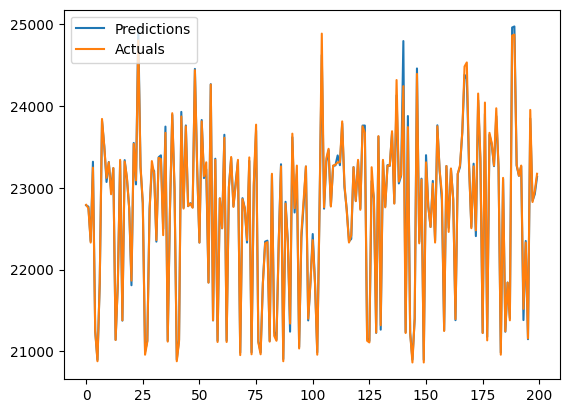

In [84]:
plot_predictions1(model, x_test, y_test, end=200)

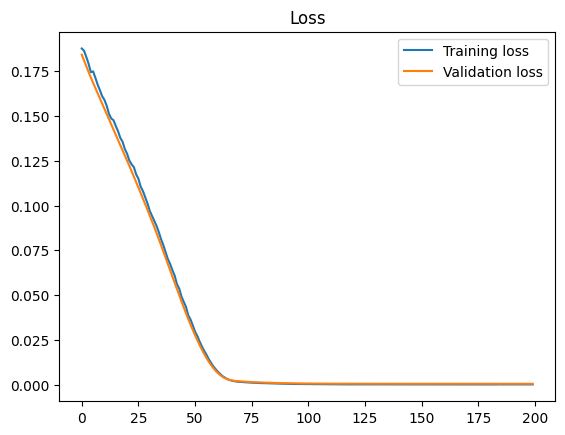

In [85]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss')
plt.legend()

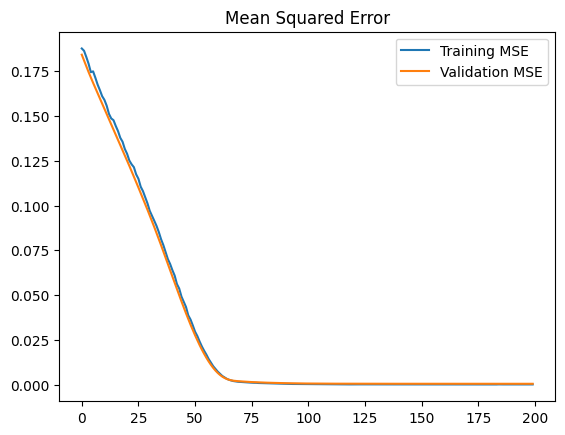

In [86]:
plt.plot(history.history['mean_squared_error'], label='Training MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
plt.title('Mean Squared Error')
plt.legend()

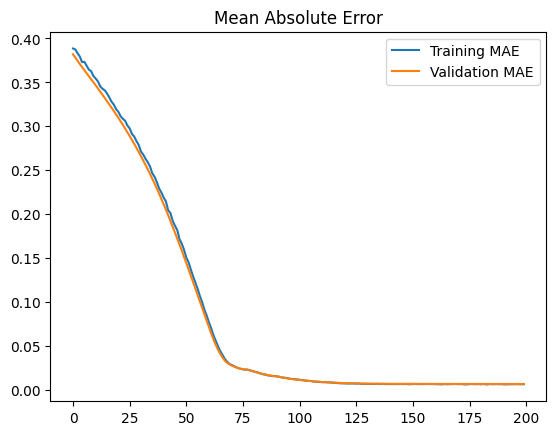

In [87]:
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Mean Absolute Error')
plt.legend()